In [2]:
import os
import shutil
from collections import Counter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image
import cv2

import seaborn as sns
from matplotlib import pyplot as plt

import engine_py
import helper_functions_py

for filename in os.listdir('/kaggle/input'):
    print(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

microscopic-fungi-images


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import time

from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion() 
print(torch.__version__)

2.0.0


# Setup device agnostic code

In [4]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Merging test-train-valid directories

As we observed during data exploration the test and valid directories are not balanced although the train directory is. We decided to merge all the directories in one directory destination_dir = '/kaggle/working/all', perform cross-validation and evaluate the model using balanced accuracy.


In [5]:
# Define the source and destination directories
source_base_dir = '/kaggle/input/microscopic-fungi-images'
destination_dir = '/kaggle/working/all'

# List of subdirectories to merge
subdirectories_to_merge = ['H1', 'H2', 'H3', 'H5', 'H6']

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Loop through each of the train, test, and val directories
for dataset_dir in ['train', 'test', 'valid']:
    # Loop through the subdirectories to merge
    for subdirectory in subdirectories_to_merge:
        # Define the source and destination paths
        source_path = os.path.join(source_base_dir, dataset_dir, subdirectory)
        destination_path = os.path.join(destination_dir, subdirectory)

        # Create a directory for the class if it doesn't exist
        if not os.path.exists(destination_path):
            os.makedirs(destination_path)

        # Copy the files from source to destination
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.copy(source_file, destination_file)

print("Files merged successfully.")

Files merged successfully.


## Check the number of images in each class after merging them

In [6]:
import os

# Define the directory path
all_directory = '/kaggle/working/all'

# List of subdirectories to check
subdirectories_to_check = ['H1', 'H2', 'H3', 'H5', 'H6']

# Loop through the subdirectories
for subdirectory in subdirectories_to_check:
    subdirectory_path = os.path.join(all_directory, subdirectory)
    
    # Check if the directory exists
    if os.path.exists(subdirectory_path):
        # Count the number of files in the directory
        files = list(os.listdir(subdirectory_path))
        print(files[0])
        num_files = len(os.listdir(subdirectory_path))
        print(f"Number of files in '{subdirectory}': {num_files}")
    else:
        print(f"'{subdirectory}' directory does not exist in '{all_directory}'.")

H1_52b_1.jpg.jpg
Number of files in 'H1': 1874
H2_29a_2.jpg.jpg
Number of files in 'H2': 1465
aug-124-H3_13c_1.jpg.jpg
Number of files in 'H3': 1163
H5_57c_4.jpg.jpg
Number of files in 'H5': 1160
H6_6b_5.jpg.jpg
Number of files in 'H6': 1139


## Load Data and Visualize them

In [8]:
DATA_DIR = all_directory

dataset = ImageFolder(DATA_DIR)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6801
    Root location: /kaggle/working/all


In [9]:
labels = dataset.targets
dataset.class_to_idx

{'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}

### Visualize a few randomly selected images

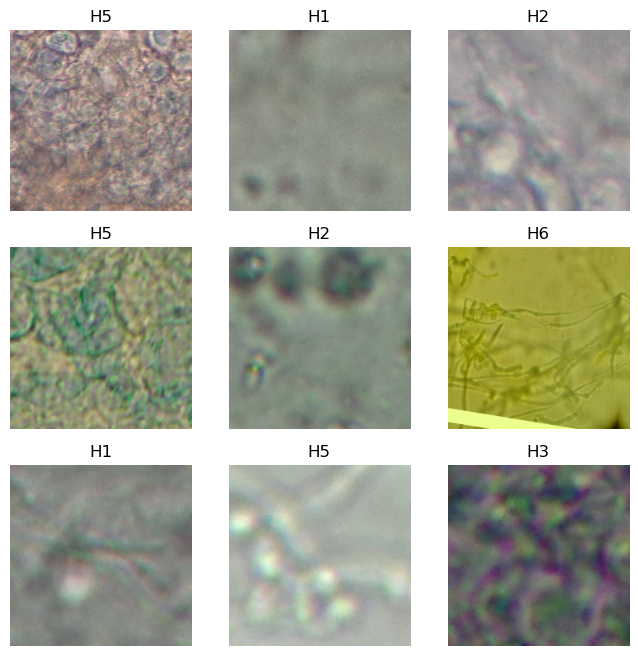

In [8]:
labels_map = {
    0: "H1",
    1: "H2",
    2: "H3",
    3: "H5",
    4: "H6",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item() # generate a random integer in the dataset range
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

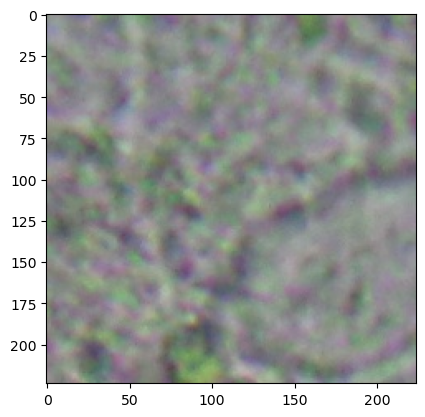

In [10]:
img, label = dataset[0]
plt.imshow(img)

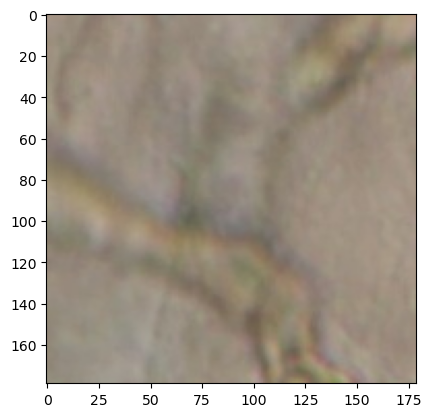

In [11]:
img, label = dataset[-1]
plt.imshow(img)

### Plot the classes' distribution

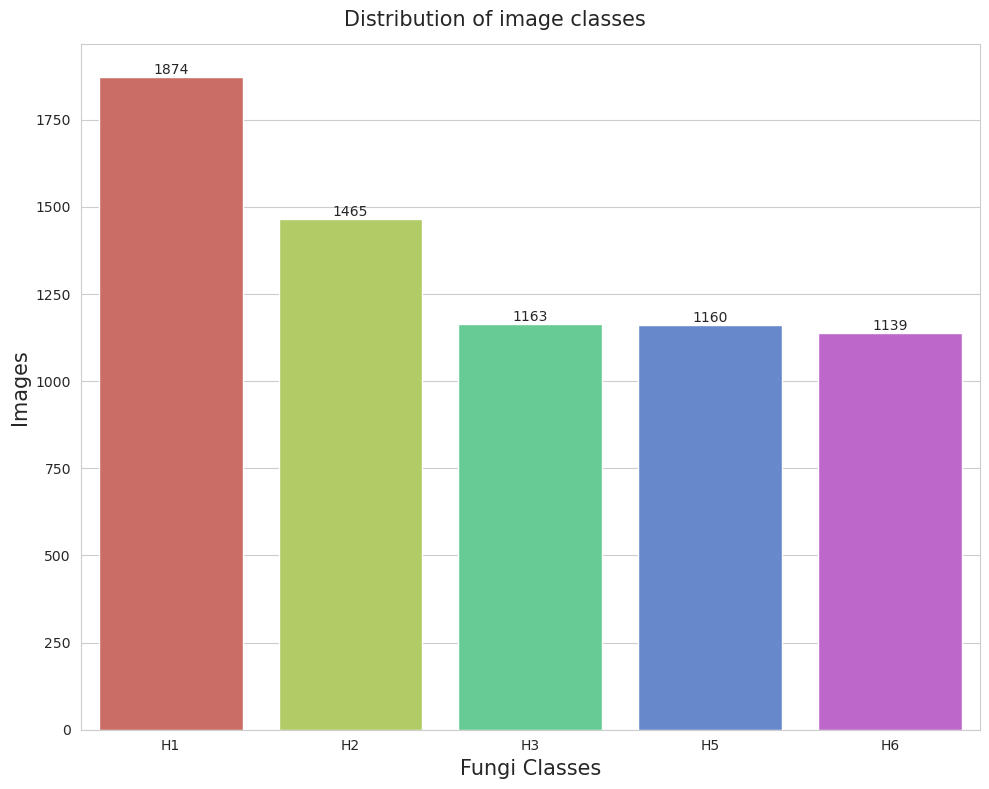

In [8]:
img_per_class = dict(Counter(dataset.targets))

plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(x=dataset.classes, y=[value for value in img_per_class.values()], color='blue', palette='hls')
ax.bar_label(ax.containers[0])

plt.xlabel('Fungi Classes', fontsize=15)
plt.ylabel(f'Images', fontsize=15)


plt.suptitle(f'Distribution of image classes', fontsize=15)
plt.savefig(f'/kaggle/working/classes_distribution.png')
plt.show()

 ## Split into stratified train,val, test subsets and store into folders (Kiriakos' function)

In [ ]:
def split_dataset(dataset, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio should be 1.0")
        
    # initial split
    train_data, test_data, train_labels, test_labels = train_test_split(
        dataset, labels, test_size=test_ratio, random_state=random_seed, stratify=labels)
    remaining_ratio = val_ratio / (train_ratio + val_ratio)
    # rain-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size=remaining_ratio, random_state=random_seed, stratify=train_labels)
    
    return train_data, val_data, test_data

# Prepare dataset for cross validation

Load dataset with different transforms to create train, test splits. 

It is important to make sure that all values are scaled to the range [0..1] before we pass them to a neural network - it is the usual convention for data preparation, and all default weight initializations in neural networks are designed to work with this range. The transform.ToTensor() method does this tranformation.

It is important to note that all images should be scaled to the same size. The transform.Resize() method performs bilinear interpolation by default.

Normalization is done with the ImageNet means and stds. When using pre-trained models like VGG16, the general recommendation is to use the same normalization parameters as those used for training the original model. This is because the pre-trained weights were optimized with that specific normalization, and using the same parameters usually yields better performance when fine-tuning or using the model for feature extraction.

The test set will be held out separately for testing the final model after cross validation

In [12]:
# Define different transforms for the train and test sets
train_transforms = transforms.Compose([
    # data augmentations can go here
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TypeError: Invalid shape (3, 224, 224) for image data

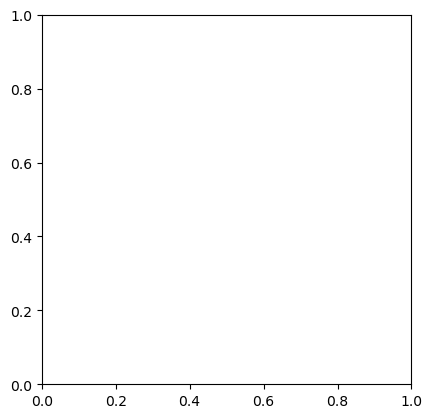

In [13]:
train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
test_dataset = ImageFolder(DATA_DIR, transform=test_transforms)

img, label = train_dataset[0]
plt.imshow(img)

img, label = train_dataset[-1]
plt.imshow(img)

# Create a list of indices from 0 to length of dataset
indices = list(range(len(train_dataset)))

# Retrieve the labels from the dataset
labels = [label for _, label in train_dataset]

# Perform stratified split
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,  # 20% test, 80% train
    stratify=labels,
    random_state=42  # To ensure reproducibility
)

# Create train, test data with Subset using the indices generated above
train_subset = Subset(train_dataset, train_idx)
train_dataset = train_subset.dataset

test_subset = Subset(test_dataset, test_idx)
test_dataset = test_subset.dataset

# Create Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
test_dataset.classes

['H1', 'H2', 'H3', 'H5', 'H6']